In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [8]:
wratDict = dict()

with open('../../PNC/wrat.csv', 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.strip().split(',')
        wratDict[line[0]] = {'raw': line[2], 'std': line[3]}

wrat = []

for key in subids:
    wrat.append(float(wratDict[str(key)]['std']))
    
wrat = np.array(wrat)
wrat_t = torch.from_numpy(wrat).float().cuda()

print(wrat_t)

tensor([114., 145.,  93.,  93., 100., 101., 112.,  95., 125., 103.,  96., 100.,
         98.,  81.,  89.,  88., 103., 108.,  94., 134., 108.,  92., 103.,  87.,
        110.,  93.,  92.,  75., 113., 113.,  92., 106., 100.,  93.,  90., 108.,
         87., 117.,  89.,  85., 103., 113.,  89., 112., 108.,  99., 101.,  89.,
         94., 104.,  93., 124., 107., 110., 128., 134., 117.,  90., 110., 130.,
         87.,  87.,  71.,  85., 128.,  89.,  96., 114.,  97., 100., 145.,  87.,
         71., 115., 144., 116.,  82.,  92.,  73., 111., 100., 109., 105.,  88.,
         79., 110., 137., 125.,  91.,  98., 112., 105.,  84., 103., 115.,  90.,
        108.,  82., 100., 102.,  93., 104.,  80., 104., 100., 145.,  93., 112.,
         90.,  92.,  81., 106.,  92., 113., 113.,  74., 112., 126.,  93., 125.,
         92., 105.,  76., 101., 121.,  76., 106., 101.,  96.,  90., 105., 100.,
        116., 122., 102.,  86., 103., 113.,  95.,  99., 113.,  98., 102.,  70.,
         93., 104., 102., 105., 126., 11

In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

males = 0
females = 0

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
    if maleness == 1:
        males += 1
    if femaleness == 1:
        females += 1
X_all = np.vstack(X_all)

print(f'{males} {females}')
print(X_all[10:20])
print('Complete')

271 322
[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

rest_p_t = convertTorch(rest_p)
nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(rest_p_t.shape)
print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([593, 34716])
torch.Size([593, 34716])
torch.Size([593, 34716])
Complete


In [25]:
Y[0,1:2].shape

torch.Size([1])

In [184]:
from torch_geometric.nn.dense import DenseGraphConv

import torch.nn as nn
import torch.nn.functional as F

def makePoly(ps):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = nPoly*[None]
        for j in range(nPoly):
            pp[j] = p**(j+1)
        pps.append(torch.stack(pp))
    return torch.stack(pps)

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = F.relu(torch.sum(A,dim=1))**0.5
    d[d == 0] = 1
    return ((A/d).T/d).T

def cosineSimilarity(a, b):
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return e

def gaussianSimilarity(a, b):
    return torch.exp(-normalize(torch.cdist(a, b)**2))

def cosineSimilarityAdjacency(a, b):
    return normalize(cosineSimilarity(a,b))#-torch.eye(a.shape[0]).float().cuda())

def gaussianSimilarityAdjacency(a, b):
    return normalize(gaussianSimilarity(a,b))

def arith(n):
    return int(n*(n+1)/2)

def getEdgeIdx(i,j,n):
    m = n-i
    return arith(n) - arith(m) + j-i

def mask(e):
    return e - torch.diag(torch.diag(e))

class FakeLayer(nn.Module):
    def __init__(self, outDim):
        super(FakeLayer, self).__init__()
        self.outDim = outDim
        
    def forward(self, x):
        return torch.zeros(x.shape[0], self.outDim).float().cuda()

width = 10

class PGIGCN(nn.Module):
    def __init__(self):
        super(PGIGCN, self).__init__()
        a = (0.01*torch.ones(nPoly*nPara*arith(263),width)
             +0.001*torch.randn(nPoly*nPara*arith(263),width)).float().cuda()
        b = [a.clone().detach() for i in range(1)]
        self.mask = nn.Parameter(torch.cat(b, dim=0))
        self.bias = nn.Parameter(0.01*torch.ones(1,nPoly*nPara*arith(263)).float().cuda())
        a = (10*torch.ones(width).float().cuda()+torch.randn(width).float().cuda())/500
        b = [a.clone().detach() for i in range(1)]
        self.gw = nn.Parameter(torch.stack(b))
        self.dp = nn.Dropout(p=0.5)
        self.mlp = MLP()
        
    def forward(self, x, xage, xgender, *args):
        x = torch.cat(x, dim=1)
        x = self.dp(x)
#         e = torch.cat([x+self.bias, xage], dim=1)@torch.cat([self.mask, self.gw], dim=0)
        e = torch.cat([x+self.bias], dim=1)@torch.cat([self.mask], dim=0)
        e = e@e.T
        idcs = xgender[:,0] == xgender[:,1]
        e[:,idcs] = 0
        e = mask(e)
        s = torch.abs(torch.sum(e, dim=1))
        e /= s.unsqueeze(1)
        sx = e@xgender
        
        return sx
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(nPara*nPoly*arith(263)+1,10).float().cuda()
        self.fc2 = nn.Linear(10,2).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        
    def forward(self, x, xage):
        x = torch.cat(x, dim=1)
        x = self.dp(x)
        x = torch.cat([x, 50*xage*nPara*nPoly/3], dim=1)
        sx = F.relu(self.fc1(x))
        sx = self.fc2(sx).squeeze(0)
        return sx
    
def laplaceReg(e, x, lam):
    return lam*torch.sum(x.T@e@x)
    
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gcn1 = DenseGraphConv(nPoly*nPara*arith(263)+1,20).float().cuda()
        self.gcn2 = DenseGraphConv(20+1,2).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, xage, e):
        x = torch.cat(x, dim=1)
        x = self.dp(x)
        x = torch.cat([x, 50*xage*nPara*nPoly/3], dim=1)
        x = F.relu(self.gcn1(x, e)).squeeze()
        x = torch.cat([x, xage/10], dim=1)
        sx = F.relu(self.gcn2(x, e)).squeeze(0)
        return sx
        

def resetWeights(m):
    with torch.no_grad():
        if hasattr(m, 'gw'):
            m.gw += 0.001*torch.randn(m.gw.shape).float().cuda()
            m.bias += 0.001*torch.randn(m.bias.shape).float().cuda()
            m.mask += 0.001*torch.randn(m.mask.shape).float().cuda()
        if hasattr(m, 'gcn1'):
            m.gcn1.reset_parameters()
            m.gcn2.reset_parameters()

nPoly = 1
para = [makePoly(nback_p_t)]
    
rmse = []
    
for i in range(10):
    pgigcn = MultiPGIGCN(5, len(para), nPoly, 0.3)
    optim = torch.optim.Adam(pgigcn.parameters(), lr=1e-5, weight_decay=1e-5)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    lossFn = torch.nn.CrossEntropyLoss()

    nEpochs = 10000
    pPeriod = 100
    thresh = 1e-1
    cPeriod = 50
    prevLoss = 0
    resetThresh = 1e-4
    
#     e = gaussianSimilarityAdjacency(mat, mat)
    e = torch.ones(2*[X[0].shape[0]]).float().cuda()
    e /= torch.sum(e, dim=1).unsqueeze(1)
    e = mask(e)
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs]
    age = Y[:,0:1]
    
    lower0 = False
    lower1 = False

    for epoch in range(nEpochs):
        optim.zero_grad()
        pred = pgigcn(X, gender=gen) #age, gen, e)
        loss = lossFn(pred, gen)
        loss.backward()
        optim.step()
        if loss < thresh:
            print(f'Early stopping {epoch}')
            break
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={loss}')
        if epoch % cPeriod == 0:
            if loss > 20*thresh and torch.abs(loss-prevLoss) < resetThresh:
                resetWeights(pgigcn)
                print('Reset')
            prevLoss = loss.detach()
        if loss < 0.3 and not lower0:
            optim.lr = 2e-6
            lower0 = True
            print('Lower 0')
        if loss < 0.2 and not lower1:
            optim.lr = 5e-7
            lower1 = True
            print('Lower 1')

    print('Finished training')
    
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t
    age = Y[:,0:1]

#     e = gaussianSimilarityAdjacency(mat, mat)
    e = torch.ones(2*[X[0].shape[0]]).float().cuda()
    e /= torch.sum(e, dim=1).unsqueeze(1)
    e = mask(e)

    y0 = gen.clone().detach()
    y0[testIdcs] = 0
    pred = pgigcn(X, gender=gen) #age, gen, e)
#     loss = lossFn(pred[testIdcs].detach(), gen[testIdcs]).cpu().numpy()**0.5
    frac = torch.sum(torch.argmax(pred, dim=1)[testIdcs] 
                     == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
    print(frac)
    
    rmse.append(float(frac))
#     rmse.append(loss)

epoch 0 loss=0.6921706199645996
epoch 100 loss=0.6921147704124451
epoch 200 loss=0.6920585632324219
epoch 300 loss=0.6920066475868225
epoch 400 loss=0.6919612884521484
epoch 500 loss=0.6919010281562805
epoch 600 loss=0.6918372511863708
epoch 700 loss=0.6917910575866699
epoch 800 loss=0.6917204856872559
epoch 900 loss=0.6916345357894897
epoch 1000 loss=0.691558301448822
epoch 1100 loss=0.6914498209953308
epoch 1200 loss=0.691325306892395
epoch 1300 loss=0.691165566444397
epoch 1400 loss=0.6909248232841492
epoch 1500 loss=0.6905389428138733
epoch 1600 loss=0.6779341697692871
epoch 1700 loss=0.32549890875816345
Lower 0
Lower 1
epoch 1800 loss=0.18287301063537598
epoch 1900 loss=0.1701471358537674
epoch 2000 loss=0.14934314787387848
epoch 2100 loss=0.12527768313884735
epoch 2200 loss=0.11310403048992157
Early stopping 2240
Finished training
tensor(0.6949, device='cuda:0')


In [183]:
for val in np.stack(rmse):
    print(val)

0.7500000596046448
0.7333333492279053
0.7666667103767395
0.8135592937469482
0.694915235042572
0.7627118825912476
0.8305084705352783
0.6779661178588867
0.7118644118309021
0.7288135886192322


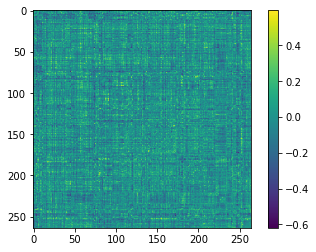

In [54]:
import matplotlib.pyplot as plt

def makeMaskImage(vec):
    m = torch.zeros((264, 264)).float().cuda()

    tril_indices = torch.triu_indices(row=264, col=264, offset=1)
    m[tril_indices[0], tril_indices[1]] = vec
    m += m.T.clone()
    
    return m

plt.imshow(makeMaskImage(torch.mean(pgigcn.masks[0][:arith(263)],dim=1).flatten()).detach().cpu().numpy())
plt.colorbar()

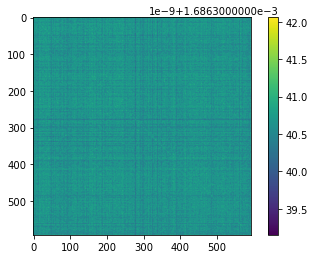

tensor([[0.0017, 0.0017, 0.0017],
        [0.0017, 0.0017, 0.0017],
        [0.0017, 0.0017, 0.0017]], device='cuda:0', grad_fn=<SliceBackward0>)


In [208]:
import matplotlib.pyplot as plt

a = cosineSimilarityAdjacency(X[1]@pgigcn.masks[3],X[1]@pgigcn.masks[3])
plt.imshow(a.detach().cpu().numpy())
plt.colorbar()
plt.show()
print(a[0:3,0:3])

In [142]:
a = X[0]@torch.rand(arith(263),100).float().cuda()
print(a[:3])
b = X[0]@torch.ones(arith(263),100).float().cuda() #pgigcn.masks[0]
print(b[:3])
e = torch.einsum('ai,bi->ab',a,b)
aa = torch.einsum('ai,ai->a',a,a)**0.5
bb = torch.einsum('ai,ai->a',b,b)**0.5
print(e[0,0:3])
print(aa[0:3])
print(bb[0:3])
print(e[0,1]/aa[0]/bb[1])
print(e[0,2]/aa[0]/bb[2])

tensor([[4485.8794, 4498.2188, 4501.1226, 4497.1479, 4479.3281, 4467.9116,
         4515.0781, 4500.7949, 4510.4775, 4501.8867, 4484.4492, 4462.0068,
         4485.2734, 4456.8682, 4518.6387, 4488.1807, 4503.3428, 4486.7026,
         4505.1372, 4511.7715, 4479.1074, 4504.4072, 4481.4746, 4503.7036,
         4507.5815, 4507.9912, 4503.8970, 4493.2656, 4500.4023, 4489.3779,
         4495.6074, 4483.4438, 4523.5127, 4477.6943, 4506.4141, 4497.1182,
         4490.4170, 4469.8350, 4492.8672, 4523.3916, 4482.2217, 4467.0293,
         4519.1265, 4470.8721, 4485.6895, 4500.5576, 4481.4341, 4489.6377,
         4487.2627, 4494.0640, 4464.2256, 4499.8071, 4512.5527, 4507.0288,
         4484.6602, 4496.2373, 4459.7295, 4503.2412, 4498.4492, 4495.4277,
         4504.5332, 4500.9736, 4489.2632, 4513.1768, 4479.1450, 4511.3428,
         4500.9277, 4501.2412, 4534.8711, 4498.6060, 4488.0874, 4525.9404,
         4496.1973, 4508.0664, 4473.0771, 4487.5303, 4529.0229, 4501.5029,
         4487.0586, 4509.

In [118]:
cosineSimilarity(a,b)[0,2]

tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)

In [122]:
(e/aa.unsqueeze(1)/aa.unsqueeze(1).T)[0,0:3]

tensor([1.5933e-08, 2.0285e-08, 8.7508e-09], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [123]:
(2*torch.ones(2,2))**0.5

tensor([[1.4142, 1.4142],
        [1.4142, 1.4142]])

In [ ]:
def cosineSimilarity(a, b):
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return e

In [85]:
n = 593
a = torch.abs(torch.randn(n,n))

def improve(a):
    for i in range(5):
        b = (a@torch.ones(n,1)).flatten()
        c = (torch.ones(1,n)@a).flatten()
        print(torch.std(b)/torch.mean(b),torch.std(c)/torch.mean(c))
        for j in range(n):
            a[j,:] *= torch.sum(b)/b[j]
            a[:,j] *= torch.sum(c)/c[j]
        a /= torch.sum(a*a)**0.5
            
print(a[0:5,0:5])
# improve(a)
# print(torch.mean(a))
a = normalize(a)
print(a[0:5,0:5])

tensor([[0.4835, 0.2779, 1.6553, 0.0428, 0.0226],
        [1.1674, 0.4219, 0.3445, 0.2012, 0.6294],
        [0.1470, 0.2425, 1.7618, 0.9671, 0.9203],
        [0.6646, 0.6553, 0.7952, 0.9371, 1.9316],
        [1.2602, 0.5063, 0.8789, 0.8349, 0.4170]])
tensor([[1.0281e-03, 5.8505e-04, 3.5170e-03, 9.2353e-05, 4.7242e-05],
        [2.4579e-03, 8.7941e-04, 7.2462e-04, 4.2960e-04, 1.3027e-03],
        [3.1239e-04, 5.1011e-04, 3.7398e-03, 2.0841e-03, 1.9222e-03],
        [1.4335e-03, 1.3994e-03, 1.7136e-03, 2.0503e-03, 4.0957e-03],
        [2.6344e-03, 1.0479e-03, 1.8358e-03, 1.7703e-03, 8.5694e-04]])


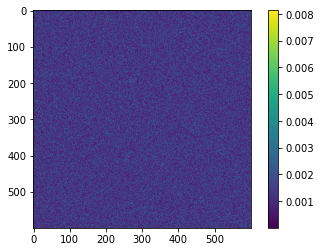

In [76]:
plt.imshow(a.numpy())
plt.colorbar()
plt.show()

In [73]:
a[0:5,0:5]

tensor([[1.4629e-03, 5.1568e-03, 1.9511e-03, 1.4499e-03, 1.2260e-03],
        [1.1485e-03, 5.4690e-04, 1.1731e-03, 3.2873e-05, 9.5353e-04],
        [1.0219e-04, 3.6921e-04, 1.2537e-03, 6.3431e-04, 1.6407e-03],
        [1.2955e-03, 5.2449e-04, 9.2650e-04, 5.9027e-04, 9.8214e-04],
        [2.4196e-03, 8.6448e-04, 3.5865e-04, 3.7697e-04, 2.8466e-03]])

In [74]:
torch.std(a)

tensor(0.0010)

In [251]:
print(torch.ones(593,593)[:,y0!=0].shape)

torch.Size([593, 533])


In [266]:
mask(torch.randn(3,3))

tensor([[ 0.0000,  0.0941, -1.5811],
        [-0.5241,  0.0000, -1.3658],
        [ 0.6285,  1.5099,  0.0000]])